<div style="width: 100%; margin: 0 auto;">
    <a href="https://github.com/e10101/learning-operations-research">
        <img src="../assets/banner.svg" alt="Learning Operations Research" style="width: 100%; height: auto; display: block;">
    </a>
</div>

# Minimum-Cost Network Flow Problems
---

[![Github](../assets/badges/github.svg)](https://github.com/e10101/learning-operations-research)


## Graphical Representation

In [ ]:
!pip install -q networkx

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Create a directed graph
G = nx.DiGraph()

In [3]:
# Add nodes
NODES = ['S', 'T1', 'T2', 'T3', 'T4', 'D']
for node in NODES:
    G.add_node(node)

In [4]:
# Add edges
EDGES = [
    ('S', 'T1'),
    ('S', 'T2'),
    ('T1', 'T2'),
    ('T1', 'T3'),
    ('T1', 'T4'),
    ('T2', 'T4'),
    ('T3', 'T4'),
    ('T3', 'D'),
    ('T4', 'D'),
]
for edge in EDGES:
    G.add_edge(*edge)

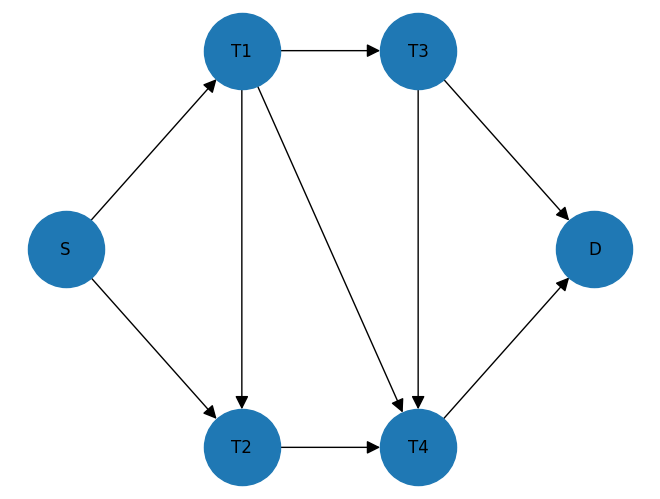

In [5]:
# Draw graph
NODE_POS = {
    'S': (0, 0),
    'T1': (1, 0.5),
    'T2': (1, -0.5),
    'T3': (2, 0.5),
    'T4': (2, -0.5),
    'D': (3, 0)
}
nx.draw(G, pos=NODE_POS, with_labels=True, node_size=3000, arrowsize=20)

In [6]:
# Add capacity and cost

CAPACITY = [
    140,
    80,
    40,
    130,
    50,
    90,
    20,
    140,
    60,
]
COST = [
    150,
    120,
    90,
    105,
    100,
    130,
    160,
    130,
    160,
]

for i in range(len(EDGES)):
    edge = EDGES[i]
    G.edges[edge]['capacity'] = CAPACITY[i]
    G.edges[edge]['cost'] = COST[i]

In [7]:
for edge in EDGES:
    print(f"edge: {edge}, with capacity: {G.edges[edge]['capacity']} and cost: {G.edges[edge]['cost']}")

edge: ('S', 'T1'), with capacity: 140 and cost: 150
edge: ('S', 'T2'), with capacity: 80 and cost: 120
edge: ('T1', 'T2'), with capacity: 40 and cost: 90
edge: ('T1', 'T3'), with capacity: 130 and cost: 105
edge: ('T1', 'T4'), with capacity: 50 and cost: 100
edge: ('T2', 'T4'), with capacity: 90 and cost: 130
edge: ('T3', 'T4'), with capacity: 20 and cost: 160
edge: ('T3', 'D'), with capacity: 140 and cost: 130
edge: ('T4', 'D'), with capacity: 60 and cost: 160


{('S',
  'T1'): Text(0.50000399039709, 0.25000199519854505, 'cap: 140, cost: 150'),
 ('S', 'T2'): Text(0.50000399039709, -0.250001995198545, 'cap: 80, cost: 120'),
 ('T1',
  'T2'): Text(0.9999999999999999, -3.00232204597517e-06, 'cap: 40, cost: 90'),
 ('T1',
  'T3'): Text(1.5000067952787504, 0.4999999999999999, 'cap: 130, cost: 105'),
 ('T1',
  'T4'): Text(1.4999945334566291, 5.466543370857835e-06, 'cap: 50, cost: 100'),
 ('T2', 'T4'): Text(1.5000067952787504, -0.5, 'cap: 90, cost: 130'),
 ('T3', 'T4'): Text(2.0, -3.00232204597517e-06, 'cap: 20, cost: 160'),
 ('T3',
  'D'): Text(2.50000399039709, 0.24999800480145495, 'cap: 140, cost: 130'),
 ('T4',
  'D'): Text(2.50000399039709, -0.24999800480145495, 'cap: 60, cost: 160')}

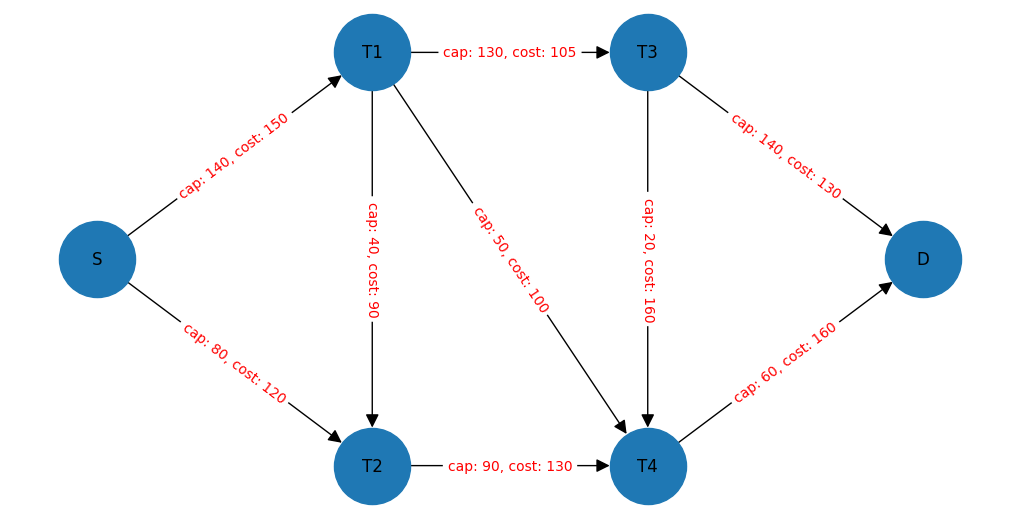

In [8]:
# Draw Graph with edge labels

plt.figure(figsize=(10, 5))

nx.draw(G, pos=NODE_POS, with_labels=True, node_size=3000, arrowsize=20)

capacity_labels = nx.get_edge_attributes(G, 'capacity')
cost_labels = nx.get_edge_attributes(G, 'cost')

edge_labels = {}
for edge, cap in capacity_labels.items():
    if edge in cost_labels:
        edge_labels[edge] = f'cap: {cap}, cost: {cost_labels[edge]}'
        
nx.draw_networkx_edge_labels(G, pos=NODE_POS, edge_labels=edge_labels, font_color='red')

## Solving with Gurobi

### Create Model

In [9]:
import gurobipy as gp

In [10]:
m = gp.Model("MCNFP")

Restricted license - for non-production use only - expires 2026-11-23


### Create Variables

In [11]:
X = m.addVars(EDGES, vtype=gp.GRB.INTEGER, lb=0, name="flow")

In [12]:
X

{('S', 'T1'): <gurobi.Var *Awaiting Model Update*>,
 ('S', 'T2'): <gurobi.Var *Awaiting Model Update*>,
 ('T1', 'T2'): <gurobi.Var *Awaiting Model Update*>,
 ('T1', 'T3'): <gurobi.Var *Awaiting Model Update*>,
 ('T1', 'T4'): <gurobi.Var *Awaiting Model Update*>,
 ('T2', 'T4'): <gurobi.Var *Awaiting Model Update*>,
 ('T3', 'T4'): <gurobi.Var *Awaiting Model Update*>,
 ('T3', 'D'): <gurobi.Var *Awaiting Model Update*>,
 ('T4', 'D'): <gurobi.Var *Awaiting Model Update*>}

### Create Constraints

In [13]:
PRODUCT = 150

In [14]:
# Constraint 1: Node in and out flows
for node in NODES:
    if node in ['S', 'D']:
        continue

    print(f'Node {node}, in: {list(G.in_edges(node))}, out: {list(G.out_edges(node))}')

    m.addConstr(sum([X[edge] for edge in G.in_edges(node)]) == sum([X[edge] for edge in G.out_edges(node)]), name=f"node_in_out_{node}")

# For S
m.addConstr(PRODUCT == sum([X[edge] for edge in G.out_edges('S')]), name="node_in_out_S")

# For D
m.addConstr(sum([X[edge] for edge in G.in_edges(node)]) == PRODUCT, name="node_in_out_D")

Node T1, in: [('S', 'T1')], out: [('T1', 'T2'), ('T1', 'T3'), ('T1', 'T4')]
Node T2, in: [('S', 'T2'), ('T1', 'T2')], out: [('T2', 'T4')]
Node T3, in: [('T1', 'T3')], out: [('T3', 'T4'), ('T3', 'D')]
Node T4, in: [('T1', 'T4'), ('T2', 'T4'), ('T3', 'T4')], out: [('T4', 'D')]


<gurobi.Constr *Awaiting Model Update*>

In [15]:
# Constraint 2: Max flow

for i in range(len(CAPACITY)):
    m.addConstr(X[EDGES[i]] <= CAPACITY[i], name=f"max_flow_{EDGES[i]}")

### Set Objective

In [16]:
m.setObjective(sum([X[EDGES[i]] * COST[i] for i in range(len(EDGES))]), sense=gp.GRB.MINIMIZE)

### Solve

In [17]:
m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (armlinux64 - "Debian GNU/Linux 11 (bullseye)")

CPU model: ARM64
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 15 rows, 9 columns and 27 nonzeros
Model fingerprint: 0x8fa230c1
Variable types: 0 continuous, 9 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+02]
Presolve removed 15 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 58250 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.825000000000e+04, best bound 5.825000000000e+04, gap 0.0000%


### Result

In [18]:
m.objVal

58250.0

In [19]:
m.getVars()

[<gurobi.Var flow[S,T1] (value 140.0)>,
 <gurobi.Var flow[S,T2] (value 10.0)>,
 <gurobi.Var flow[T1,T2] (value -0.0)>,
 <gurobi.Var flow[T1,T3] (value 130.0)>,
 <gurobi.Var flow[T1,T4] (value 10.0)>,
 <gurobi.Var flow[T2,T4] (value 10.0)>,
 <gurobi.Var flow[T3,T4] (value -0.0)>,
 <gurobi.Var flow[T3,D] (value 130.0)>,
 <gurobi.Var flow[T4,D] (value 20.0)>]

In [20]:
for c in m.getConstrs():
    print(f"{c.ConstrName} - Slack: {c.Slack}")

node_in_out_T1 - Slack: 0.0
node_in_out_T2 - Slack: 0.0
node_in_out_T3 - Slack: 0.0
node_in_out_T4 - Slack: 0.0
node_in_out_S - Slack: 0.0
node_in_out_D - Slack: 0.0
max_flow_('S', 'T1') - Slack: 0.0
max_flow_('S', 'T2') - Slack: 70.0
max_flow_('T1', 'T2') - Slack: 40.0
max_flow_('T1', 'T3') - Slack: 0.0
max_flow_('T1', 'T4') - Slack: 40.0
max_flow_('T2', 'T4') - Slack: 80.0
max_flow_('T3', 'T4') - Slack: 20.0
max_flow_('T3', 'D') - Slack: 10.0
max_flow_('T4', 'D') - Slack: 40.0


{('T1',
  'T2'): Text(0.9999999999999999, -3.00232204597517e-06, '0/40, cost: 90'),
 ('T3', 'T4'): Text(2.0, -3.00232204597517e-06, '0/20, cost: 160')}

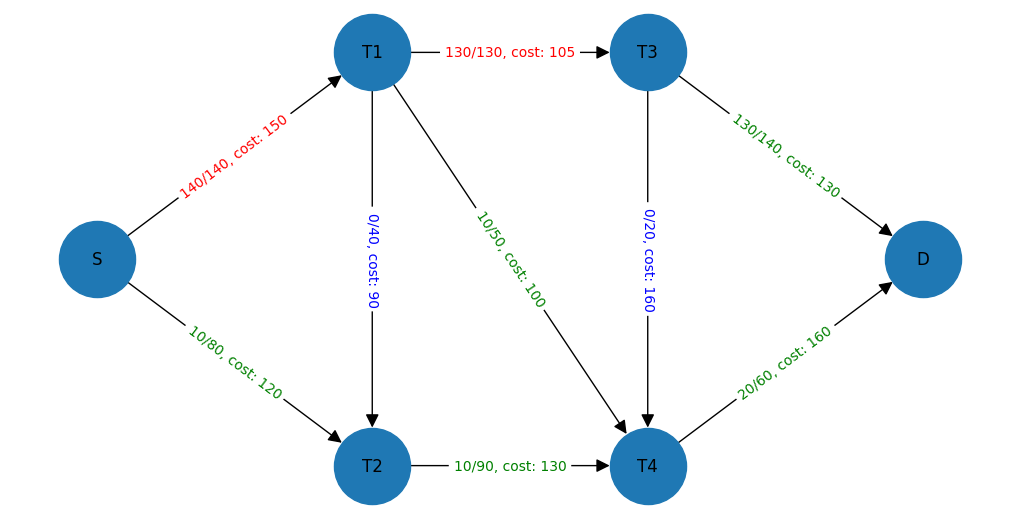

In [21]:
# Draw Graph with edge labels

plt.figure(figsize=(10, 5))

nx.draw(G, pos=NODE_POS, with_labels=True, node_size=3000, arrowsize=20)

capacity_labels = nx.get_edge_attributes(G, 'capacity')
cost_labels = nx.get_edge_attributes(G, 'cost')

full_edge_labels = {}
part_edge_labels = {}
zero_edge_labels = {}
for edge, cap in capacity_labels.items():
    if edge in cost_labels:
        if abs(X[edge].X) == 0:
            zero_edge_labels[edge] = f'{abs(X[edge].X):.0f}/{cap}, cost: {cost_labels[edge]}'
        elif cap - abs(X[edge].X) > 0:
            part_edge_labels[edge] = f'{abs(X[edge].X):.0f}/{cap}, cost: {cost_labels[edge]}'
        else:
            full_edge_labels[edge] = f'{abs(X[edge].X):.0f}/{cap}, cost: {cost_labels[edge]}'
        
nx.draw_networkx_edge_labels(G, pos=NODE_POS, edge_labels=full_edge_labels, font_color='red')
nx.draw_networkx_edge_labels(G, pos=NODE_POS, edge_labels=part_edge_labels, font_color='green')
nx.draw_networkx_edge_labels(G, pos=NODE_POS, edge_labels=zero_edge_labels, font_color='blue')

### Debug

In [22]:
if m.status == gp.GRB.INFEASIBLE:
    m.computeIIS()

    print("Constrs")

    for c in m.getConstrs():
        if c.IISConstr:
            print(f"{c.ConstrName}")